In [1]:
# !pip install surprise


In [4]:
import math
import numpy as np
import pandas as pd
from collections import defaultdict
# Split the data into train and test sets
from surprise import Reader, Dataset
from surprise import accuracy
# importing relevant libraries
from surprise.model_selection import cross_validate, GridSearchCV,train_test_split
from surprise.prediction_algorithms import SVD, KNNBasic, KNNBaseline
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering


In [5]:
df = pd.read_csv(r'/Users/royzalta/Documents/Data Science Course/data_recom_sys/Books Data with Category Language and Summary/Preprocessed_data.csv')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# df = pd.read_csv(r"/content/drive/My Drive/Preprocessed_data.csv")

In [6]:
from book_funcs import df_cleaner, zero_droper, precision_recall_at_k
df = df_cleaner(df)
df = zero_droper(df)

The original data frame shape:	(1031175, 19)
The data frame shape after bookk filtering:	(629588, 19)
The new data frame shape:	(581111, 19)


# optional for reduce memory consamption

In [7]:

min_book_ratings = 5
filter_books = df['isbn'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 2
filter_users = df['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['isbn'].isin(filter_books)) & (df['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

df_new = df_new[df_new['rating']>0]

The original data frame shape:	(206820, 19)
The new data frame shape:	(136754, 19)


# models

In [8]:
reader = Reader()
data = Dataset.load_from_df(df_new[['user_id', 'isbn', 'rating']], reader)

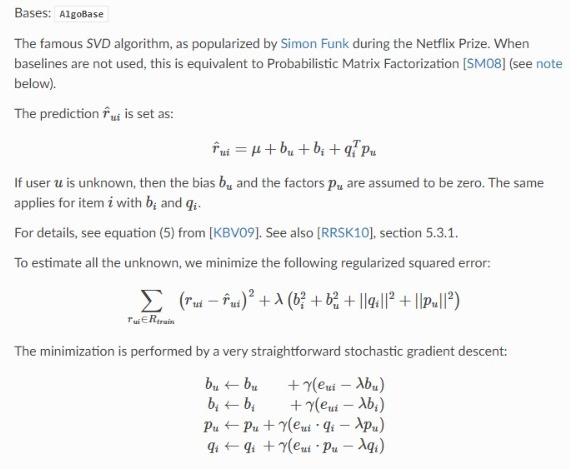

In [9]:
svd = SVD( n_epochs=10)
res = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    3.2951  3.2862  3.3024  3.2946  0.0066  
MAE (testset)     2.9091  2.9000  2.9198  2.9097  0.0081  
Fit time          0.55    0.58    0.56    0.56    0.01    
Test time         0.28    0.16    0.27    0.24    0.06    


In [10]:
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split

param_grid = {
  'n_factors': [15,20,30],
  'n_epochs': [10, 8]
}

gsSVD = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gsSVD.fit(data)

print(gsSVD.best_score['rmse'])
print(gsSVD.best_params['rmse'])

3.2945408656135107
{'n_factors': 15, 'n_epochs': 10}


In [11]:
from surprise.model_selection import GridSearchCV

param_grid = {
  'n_factors': [15,20,30],
  'n_epochs': [10, 8]
}

gsSVD = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gsSVD.fit(data)

print(gsSVD.best_score['rmse'])
print(gsSVD.best_params['rmse'])
# best hyperparameters
best_factor = gsSVD.best_params['rmse']['n_factors']
best_epoch = gsSVD.best_params['rmse']['n_epochs']

# sample random trainset and testset
# test set is made of 20% of the ratings.
trainset, testset = train_test_split(data, test_size=.20)

# We'll use the famous SVD algorithm.
svd = SVD(n_factors=best_factor, n_epochs=best_epoch)

# Train the algorithm on the trainset
svd.fit(trainset)


3.2945686082068364
{'n_factors': 20, 'n_epochs': 10}


with svd++

In [12]:
# רועי אשמח אם תוכל להריץ את זה

param_grid = {
  'n_factors': [20,30, 10],
  'n_epochs': [5, 10]
}
from surprise.model_selection import GridSearchCV

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

3.294551493341617
{'n_factors': 10, 'n_epochs': 5}


with NMF

In [13]:
# רועי אשמח אם תוכל להריץ את זה

from surprise import NMF

param_grid = {
  'n_factors': [20, 40, 10],
  'n_epochs': [5, 10, 15]
}

gsNMF = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=4)
gsNMF.fit(data)

print(gsNMF.best_score['rmse'])
print(gsNMF.best_params['rmse'])

3.295504240663387
{'n_factors': 10, 'n_epochs': 5}


In [14]:
benchmark = []


In [15]:

# Iterate over all algorithms
#SVDpp(),NMF(),
for algorithm in [SVD(), SlopeOne(),  NormalPredictor()]:
    # Perform cross validation
    print(algorithm)
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=4, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,3.294602,1.223517,0.164850
SlopeOne,3.341663,1.062787,0.754538
NormalPredictor,3.341952,0.092728,0.119722


In [16]:
for algorithm in [BaselineOnly(), CoClustering()]:
    # Perform cross validation
    print(algorithm)
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    print(tmp)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    print(tmp)

    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
test_rmse    3.294551
fit_time     0.177551
test_time    0.094633
dtype: float64
test_rmse        3.294551
fit_time         0.177551
test_time        0.094633
Algorithm    BaselineOnly
dtype: object
test_rmse    3.309331
fit_time     2.278064
test_time    0.158587
dtype: float64
test_rmse        3.309331
fit_time         2.278064
test_time        0.158587
Algorithm    CoClustering
dtype: object


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,3.294551,0.177551,0.094633
SVD,3.294602,1.223517,0.164850
CoClustering,3.309331,2.278064,0.158587
SlopeOne,3.341663,1.062787,0.754538
NormalPredictor,3.341952,0.092728,0.119722


In [17]:
# רועי אשמח אם תוכל להריץ את זה
# Iterate over all algorithms
for algorithm in [SVDpp(),NMF()]:
    # Perform cross validation
    print(algorithm)
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,3.294551,0.177551,0.094633
SVD,3.294602,1.223517,0.164850
SVDpp,3.295141,5.277104,2.071366
CoClustering,3.309331,2.278064,0.158587
SlopeOne,3.341663,1.062787,0.754538
NormalPredictor,3.341952,0.092728,0.119722
NMF,3.419685,2.221274,0.221912


In [18]:
res_pd = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
res_pd['recall@k'] = 0
res_pd['precision@k'] = 0

Cold Start Problem
If we split the data in any way, we may run into something called the cold start problem, meaning that some users or movies are only present in the test set, but not in the training set. In our case, funnily enough, user 1 is such an example.

### צריך לשמור את הטבלה שמתקבלת פה כקובץ ולהעלות אותה לגיט

In [20]:
res_pd = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
res_pd['recall@k'] = 0
res_pd['precision@k'] = 0
for name,algo in [('SVD',SVD()),('SVDpp',SVDpp()),('NMF',NMF()), ('SlopeOne',SlopeOne()), ('NormalPredictor',NormalPredictor()),('BaselineOnly',BaselineOnly()), ('CoClustering',CoClustering())]:
    trainset, testset = train_test_split(data, test_size=.20)
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=5)
    res_pd.loc[name,'recall@k'] = sum(rec for rec in recalls.values() if rec !=None) / len(list(rec for rec in recalls.values() if rec !=None))
    res_pd.loc[name,'precision@k'] = sum(prec for prec in precisions.values() if prec !=None) / len(list(prec for prec in precisions.values() if prec !=None))



Estimating biases using als...


In [21]:
res_pd

,test_rmse,fit_time,test_time,recall@k,precision@k
Algorithm,,,,,
BaselineOnly,3.294551,0.177551,0.094633,0.984237,0.955624
SVD,3.294602,1.223517,0.164850,0.984539,0.958040
SVDpp,3.295141,5.277104,2.071366,0.984225,0.957952
CoClustering,3.309331,2.278064,0.158587,0.940312,0.962697
SlopeOne,3.341663,1.062787,0.754538,0.932281,0.958570
NormalPredictor,3.341952,0.092728,0.119722,0.926111,0.955920
NMF,3.419685,2.221274,0.221912,0.725338,0.967499


In [22]:
res_pd.to_csv('matrix_fact_results.csv')

### עד כאן

בעיה - יש הרבה קוראים שלא דירגו 10 ספרים, צריך לראות איך זה מתייחס אליהם

In [23]:
# רועי אשמח אם תוכל להריץ את זה

for algorithm in [ KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    print(algorithm)
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,3.294551,0.177551,0.094633
SVD,3.294602,1.223517,0.164850
SVDpp,3.295141,5.277104,2.071366
CoClustering,3.309331,2.278064,0.158587
KNNWithMeans,3.322369,2.390191,0.990116
KNNWithZScore,3.324347,2.546009,0.957999
SlopeOne,3.341663,1.062787,0.754538
NormalPredictor,3.341952,0.092728,0.119722
NMF,3.419685,2.221274,0.221912


In [24]:
# רועי אשמח אם תוכל להריץ את זה

for algorithm in [ KNNBaseline(), KNNBasic()]:
    # Perform cross validation
    print(algorithm)
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,3.294551,0.177551,0.094633
SVD,3.294602,1.223517,0.164850
SVDpp,3.295141,5.277104,2.071366
CoClustering,3.309331,2.278064,0.158587
KNNBaseline,3.310971,2.341193,1.050708
KNNBasic,3.311907,2.317330,0.822065
KNNWithMeans,3.322369,2.390191,0.990116
KNNWithZScore,3.324347,2.546009,0.957999
SlopeOne,3.341663,1.062787,0.754538


Limit cases
In the computation of precision@k, we are dividing by the number of items recommended in the top-k recommendation. If there are no items recommended. i.e. number of recommended items at k is zero, we cannot compute precision at k since we cannot divide by zero. In that case we set precision at k to 1. This makes sense because in that case we do not have any recommended item that is not relevant.

Similarly, when computing recall@k we might face a similar situation when the total number of relevant items is zero. In that case we set recall at k to be 1. This also makes sense because we do not have any relevant item that is not identified in our top-k results.